# GEMINI GENERATIVE CODE

In [ ]:
# ----------------------------------------------------------------------
# 1. SETUP AND MOUNT GOOGLE DRIVE
# ----------------------------------------------------------------------
import os
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')
print("Google Drive mounted successfully. ✅")

# Define the paths based on your structure: /content/drive/My Drive/Spoof_data/{train, test}/{live, spoof}/img.png
BASE_PATH = '/content/drive/My Drive/Spoof_data'
TRAIN_DIR = os.path.join(BASE_PATH, 'train') # Correctly points to /.../train/
TEST_DIR = os.path.join(BASE_PATH, 'test')   # Correctly points to /.../test/

# --- Model Parameters ---
IMG_WIDTH, IMG_HEIGHT = 128, 128
CHANNELS = 3
BATCH_SIZE = 32
EPOCHS = 10
CLASS_NAMES = ['live', 'spoof']

# Verify the paths exist
if not os.path.exists(TRAIN_DIR) or not os.path.exists(TEST_DIR):
    print("\n--- CRITICAL ERROR ---")
    print(f"Directory not found. Please ensure 'train' and 'test' are in: {BASE_PATH}")
    raise FileNotFoundError("Check your Google Drive path and structure.")
else:
    print(f"Data directories set: \nTrain: {TRAIN_DIR}\nTest: {TEST_DIR}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully. ✅
Data directories set: 
Train: /content/drive/My Drive/Spoof_data/train
Test: /content/drive/My Drive/Spoof_data/test


In [ ]:
# Data augmentation for training data and normalization for both
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255) # Only normalization for test data

print("\nLoading training data...")
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='rgb' if CHANNELS == 3 else 'grayscale',
    shuffle=True
)

print("Loading testing data...")
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='rgb' if CHANNELS == 3 else 'grayscale',
    shuffle=False # Crucial for evaluation
)

print(f"Class Indices (0/1 mapping): {train_generator.class_indices}")


Loading training data...
Found 407 images belonging to 2 classes.
Loading testing data...
Found 400 images belonging to 2 classes.
Class Indices (0/1 mapping): {'live': 0, 'spoof': 1}


In [ ]:
# ----------------------------------------------------------------------
# 3. DEFINING THE CNN BASELINE MODEL
# ----------------------------------------------------------------------

input_shape = (128, 128, 3)  # change as needed

model = Sequential([
    # --- Feature Extraction Layers ---
    # 1st Convolutional Block
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D((2, 2)),

    # 2nd Convolutional Block
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # 3rd Convolutional Block
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # --- Classification Layers ---
    Flatten(),  # Flatten the 3D output to 1D for the Dense layers
    Dense(512, activation='relu'),  # Fully Connected Layer 1
    Dropout(0.5),  # Regularization to prevent overfitting

    # Output Layer: Binary Classification (1 for Live, 0 for Spoof)
    Dense(1, activation='sigmoid')  # 'sigmoid' outputs probability between 0 and 1
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',  # Appropriate loss for binary classification
    metrics=['accuracy']
)

print("\n--- Model Summary ---")
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



--- Model Summary ---


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_21 (Conv2D)              │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,939,329 (49.36 MB)

 Trainable params: 12,939,329 (49.36 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# ----------------------------------------------------------------------
# 4. MODEL TRAINING
# ----------------------------------------------------------------------
print("\n--- Starting Training ---")
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=test_generator,
    validation_steps=test_generator.samples // BATCH_SIZE
)


--- Starting Training ---
Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.5492 - loss: 0.7197 - val_accuracy: 0.4896 - val_loss: 0.6716
Epoch 2/10
 1/12 ━━━━━━━━━━━━━━━━━━━━ 10s 972ms/step - accuracy: 0.5000 - loss: 0.7394

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 484ms/step - accuracy: 0.5000 - loss: 0.7394 - val_accuracy: 0.7161 - val_loss: 0.6331
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 41s 4s/step - accuracy: 0.6137 - loss: 0.6446 - val_accuracy: 0.7240 - val_loss: 0.5317
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 625ms/step - accuracy: 0.6250 - loss: 0.6336 - val_accuracy: 0.7240 - val_loss: 0.5546
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.6914 - loss: 0.5648 - val_accuracy: 0.7005 - val_loss: 0.6022
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 557ms/step - accuracy: 0.6250 - loss: 0.5891 - val_accuracy: 0.6406 - val_loss: 0.6851
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 40s 4s/step - accuracy: 0.7474 - loss: 0.5681 - val_accuracy: 0.5625 - val_loss: 0.8507
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 556ms/step - accuracy: 0.6875 - loss: 0.5722 - val_accuracy: 0.5938 - val_loss: 0.8193
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.7976 - loss: 0.5039 - val_accuracy: 0.5599 - val_loss: 0.

In [ ]:
# ----------------------------------------------------------------------
# 5. EVALUATION AND SAVING
# ----------------------------------------------------------------------

print("\nEvaluating model performance...")

# Get predictions on the test set
test_generator.reset()
Y_pred = model.predict(test_generator, steps=test_generator.samples // BATCH_SIZE + 1)

# Convert probabilities to class labels (0 or 1)
y_pred_classes = np.round(Y_pred).astype(int).flatten()

# Get true labels and slice to match the prediction size
y_true = test_generator.classes[:len(y_pred_classes)]

# Define target names based on the class indices for the report
target_names = [name for name, index in sorted(train_generator.class_indices.items(), key=lambda item: item[1])]

# Print Classification Report
print("\n--- Classification Report ---")
print(classification_report(y_true, y_pred_classes, target_names=target_names))

# Print Confusion Matrix
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_true, y_pred_classes)
print(cm)




Evaluating model performance...
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 507ms/step

--- Classification Report ---
              precision    recall  f1-score   support

        live       1.00      0.15      0.26       200
       spoof       0.54      1.00      0.70       200

    accuracy                           0.57       400
   macro avg       0.77      0.57      0.48       400
weighted avg       0.77      0.57      0.48       400


--- Confusion Matrix ---
[[ 30 170]
 [  0 200]]


# Updated with new prompt


Visualizing some training images after augmentation...


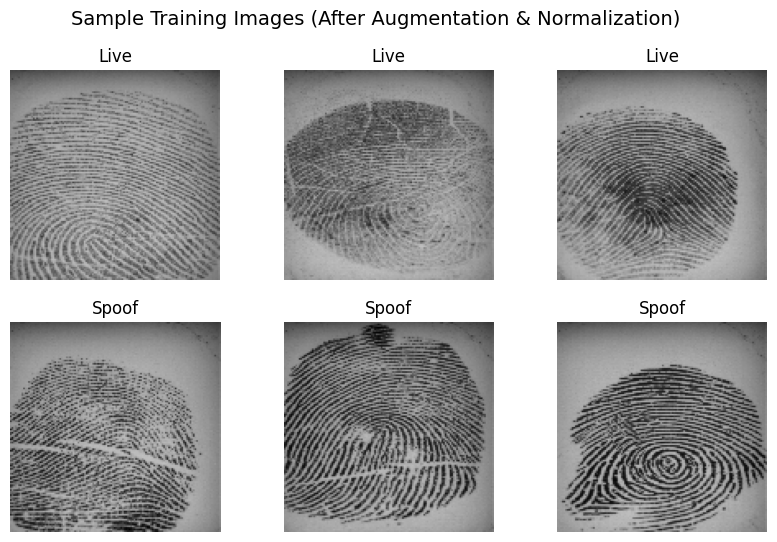

In [ ]:
# ----------------------------------------------------------------------
#VISUAL INSPECTION: AUGMENTED TRAINING IMAGES
# ----------------------------------------------------------------------
import matplotlib.pyplot as plt

print("\nVisualizing some training images after augmentation...")

# Take one batch of training images
x_batch, y_batch = next(train_generator)

plt.figure(figsize=(10, 6))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(x_batch[i])
    plt.title(f"{'Live' if y_batch[i] == 0 else 'Spoof'}")
    plt.axis('off')

plt.suptitle("Sample Training Images (After Augmentation & Normalization)", fontsize=14)
plt.show()



--- Model Summary ---


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,939,329 (49.36 MB)

 Trainable params: 12,939,329 (49.36 MB)

 Non-trainable params: 0 (0.00 B)

---------------------

Starting model training...
Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.5147 - loss: 0.8323 - val_accuracy: 0.4792 - val_loss: 0.7068
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 629ms/step - accuracy: 0.5000 - loss: 0.6936 - val_accuracy: 0.6979 - val_loss: 0.6525
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.6531 - loss: 0.6535 - val_accuracy: 0.7214 - val_loss: 0.5444
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 795ms/step - accuracy: 0.6250 - loss: 0.6385 - val_accuracy: 0.8099 - val_loss: 0.5094
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 41s 4s/step - accuracy: 0.6537 - loss: 0.6112 - val_accuracy: 0.7839 - val_loss: 0.5047
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 641ms/step - accuracy: 0.5000 - loss: 0.7040 - val_accuracy: 0.7526 - val_loss: 0.5388
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 81s 4s/step - accuracy: 0.7371 - loss: 0.5324 - val_accuracy: 0.7734 - val_loss: 0.4915
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 516ms/step - accurac

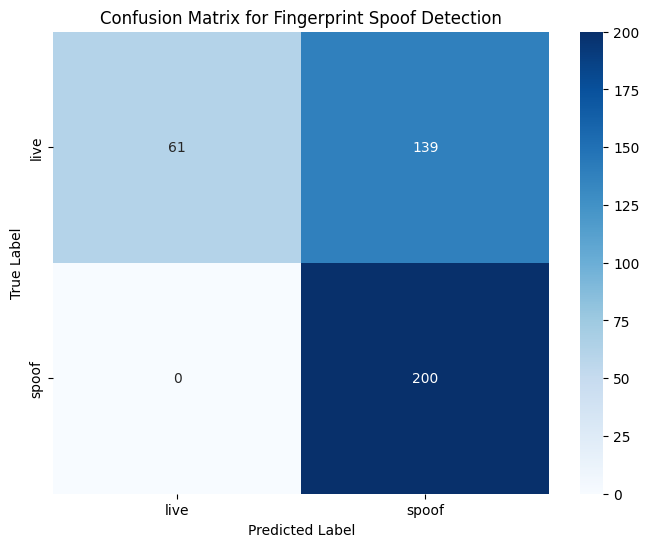

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

input_shape = (128, 128, 3)  # change as needed

model = Sequential([
    # --- Feature Extraction Layers ---
    # 1st Convolutional Block
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D((2, 2)),

    # 2nd Convolutional Block
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # 3rd Convolutional Block
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # --- Classification Layers ---
    Flatten(),  # Flatten the 3D output to 1D for the Dense layers
    Dense(512, activation='relu'),  # Fully Connected Layer 1
    Dropout(0.5),  # Regularization to prevent overfitting

    # Output Layer: Binary Classification (1 for Live, 0 for Spoof)
    Dense(1, activation='sigmoid')  # 'sigmoid' outputs probability between 0 and 1
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("\n--- Model Summary ---")
model.summary()
print("---------------------\n")

# --- 4. Model Training ---

print("Starting model training...")
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=test_generator,
    validation_steps=test_generator.samples // BATCH_SIZE
)
print("\n--- Training Complete ---\n")

# --- 5. Model Evaluation and Results ---

print("Evaluating model on test data and generating metrics...")

# Get predictions on the test set
# The 'steps' parameter ensures all test samples are processed, rounding up if necessary.
steps = int(np.ceil(test_generator.samples / BATCH_SIZE))
test_predictions_prob = model.predict(test_generator, steps=steps)

# Convert probabilities to class labels (0 or 1)
test_predictions = (test_predictions_prob > 0.5).astype(int)

# Get true labels. We only need the first 'n' labels that match the number of predictions.
test_true_labels = test_generator.classes[:len(test_predictions)]

# Check for length mismatch (can happen with final partial batch in flow_from_directory)
if len(test_predictions) != len(test_true_labels):
    print(f"Warning: Prediction length ({len(test_predictions)}) does not match true label length ({len(test_generator.classes)}). Trimming true labels.")
    test_true_labels = test_generator.classes[:len(test_predictions)]


# --- Classification Report ---
print("\n## Classification Report")
# Ensure the target names match the true indices:
# 'live' is the positive class (1), 'spoof' is the negative class (0) based on directory order.
# We reverse class_labels to map 0 -> 'spoof', 1 -> 'live' if that's the order in class_indices
target_names = [name for name, index in sorted(train_generator.class_indices.items(), key=lambda item: item[1])]
print(f"Target mapping: 0={target_names[0]}, 1={target_names[1]}")

print(classification_report(test_true_labels, test_predictions, target_names=target_names))


# --- Confusion Matrix ---
print("\n## Confusion Matrix")
conf_matrix = confusion_matrix(test_true_labels, test_predictions)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt='d', # 'd' formats the numbers as integers
    cmap='Blues',
    xticklabels=target_names,
    yticklabels=target_names
)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Fingerprint Spoof Detection')
plt.show()